# Movie Sentiment Analysis with Keras

This notebok is based on the following article: https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

The keras.datasets.imdb.load_data() allows you to load the dataset in a format that is ready for use in neural network and deep learning models.
The words have been replaced by integers that indicate the absolute popularity of the word in the dataset. The sentences in each review therefore consist of a sequence of integers.
This contrasts with how we have been loading the data set in other notebooks, where we have to prepare the data before it can be split into train and test.

In [11]:
# MLP for the IMDB problem
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence
from matplotlib import pyplot
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [1]:
# load the dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = numpy.concatenate((X_train, X_test), axis=0)
y = numpy.concatenate((y_train, y_test), axis=0)

Using TensorFlow backend.


In [2]:
# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

Training data: 
(50000,)
(50000,)


In [3]:
# Summarize number of classes
print("Classes: ")
print(numpy.unique(y))

Classes: 
[0 1]


In [4]:
# Summarize number of words
print("Number of words: ")
print(len(numpy.unique(numpy.hstack(X))))

Number of words: 
88585


Review length: 
Mean 234.76 words (172.911495)


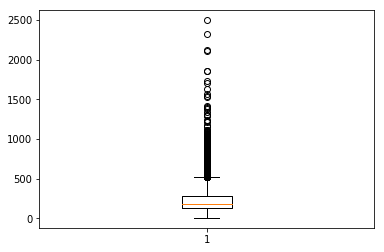

In [5]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (numpy.mean(result), numpy.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

### Word Embeddings
Word Embedding is a technique where words are encoded as real-valued vectors in a high-dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.
Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding layer.

To simplify what follows the IMDB dataset is reloaded, but only the top 5,000 words will be loaded.
The dataset is into training and test based a 50%/50% split, but it is probably more usual to use an 80/20 split.

In [7]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

Bound reviews at 500 words, truncating longer reviews and zero-padding shorter reviews.

In [8]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

The model below uses an Embedding layer as the input layer, setting the vocabulary to 5,000, the word vector size to 32 dimensions and the input_length to 500. The output of this first layer will be a 32×500 sized matrix.

Then the Embedded layers are flattened to produce an output of one dimension, which then uses a dense hidden layer of 250 units with a rectifier activation function. The output layer has one neuron and uses a sigmoid activation to output values of 0 and 1 as predictions.

In [9]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 10s - loss: 0.5102 - acc: 0.7109 - val_loss: 0.3090 - val_acc: 0.8667
Epoch 2/2
 - 10s - loss: 0.1903 - acc: 0.9276 - val_loss: 0.3003 - val_acc: 0.8731
Accuracy: 87.31%


A better result (0.8825) can be obtained if the output layer is changed to softmax activation.

In [17]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# Fit the model again
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 11s - loss: 0.6513 - acc: 0.6832 - val_loss: 0.5690 - val_acc: 0.8662
Epoch 2/2
 - 10s - loss: 0.5153 - acc: 0.8902 - val_loss: 0.4873 - val_acc: 0.8825
Accuracy: 88.25%


## CNN Approach

In [12]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [19]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 251       
Total params: 2,163,605
Trainable params: 2,163,605
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 12s - loss: 0.6443 - acc: 0.7017 - val_loss: 0.5711 - val_acc: 0.8591
Epoch 2/2
 - 12s - loss: 0.5208 - acc: 0.8920 - val_loss: 0.4956 - val_acc: 0.8846
Accuracy: 88.46%


## Why did the CNN improve the accuracy?

Well, it only improved it by a tiny amount. Perhaps the CNNs are better at capturing the spatial relationships or the LSTM needs to be larger and trained for longer to achieve the same accuracy.

Removing the denser layer with 250 neurons reduces the number of parameters needed to be trained drastically with an increased accuracy of about 1% over 5 epochs. Maybe the 2 dense layers after flatten layer should not be there.